In [84]:
#Reall Sales_train

import pandas as pd
import numpy as np

#Load the data
sales_train = pd.read_csv('sales_train.csv')


In [85]:
sales_train.shape

(2935849, 6)

In [86]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


https://www.kaggle.com/datasets/ndarshan2797/english-converted-datasets/data

In [87]:
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')


In [88]:
sales_train.shape, items.shape, item_categories.shape, shops.shape

((2935849, 6), (22170, 3), (84, 2), (60, 2))

In [89]:
item_categories.columns = ['category_name', 'category_id']

In [90]:
merged_data = sales_train.merge(items, on='item_id', how='left') \
                        .merge(shops, on='shop_id', how='left') \
                        .merge(item_categories, left_on='category_id', right_on='category_id', how='left')

 

In [91]:
merged_data.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'category_id', 'shop_name',
       'category_name'],
      dtype='object')

In [92]:
merged_data.item_cnt_day.value_counts()

item_cnt_day
1.0       2629372
2.0        194201
3.0         47350
4.0         19685
5.0         10474
           ...   
251.0           1
501.0           1
112.0           1
164.0           1
2169.0          1
Name: count, Length: 198, dtype: int64

In [93]:
sales_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [94]:
# merged_data.to_csv('merged_data.csv', index=False)

In [95]:
merged_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,category_id,shop_name,category_name
0,02.01.2013,0,59,22154,999.00,1.0,SCENE 2012 (BD),37,"Yaroslavl TC"" Altair """,Cinema - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Moscow TEC"" Atrium """,Music - Vinyl
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Moscow TEC"" Atrium """,Music - Vinyl
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Moscow TEC"" Atrium """,Music - Vinyl
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Businesses).,56,"Moscow TEC"" Atrium """,Music - CD of corporate production


In [96]:
# Check for missing values
print(sales_train.isnull().sum())
print(items.isnull().sum())
print(item_categories.isnull().sum())
print(shops.isnull().sum())

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
item_name      0
item_id        0
category_id    0
dtype: int64
category_name    0
category_id      0
dtype: int64
shop_name    0
shop_id      0
dtype: int64


In [97]:
# Handle outliers in 'item_cnt_day' and 'item_price'
sales_train = sales_train[sales_train['item_cnt_day'] <= 1000]
sales_train = sales_train[sales_train['item_price'] <= 100000]

In [98]:
# Aggregate sales by month, shop, and item
monthly_sales = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
    'item_cnt_day': 'sum',
    'item_price': 'mean'
}).reset_index().rename(columns={'item_cnt_day': 'item_cnt_month'})


In [99]:
monthly_sales

,date_block_num,shop_id,item_id,item_cnt_month,item_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5
...,...,...,...,...,...
1609118,33,59,22087,6.0,119.0
1609119,33,59,22088,2.0,119.0
1609120,33,59,22091,1.0,179.0
1609121,33,59,22100,1.0,629.0


<Axes: xlabel='date_block_num'>

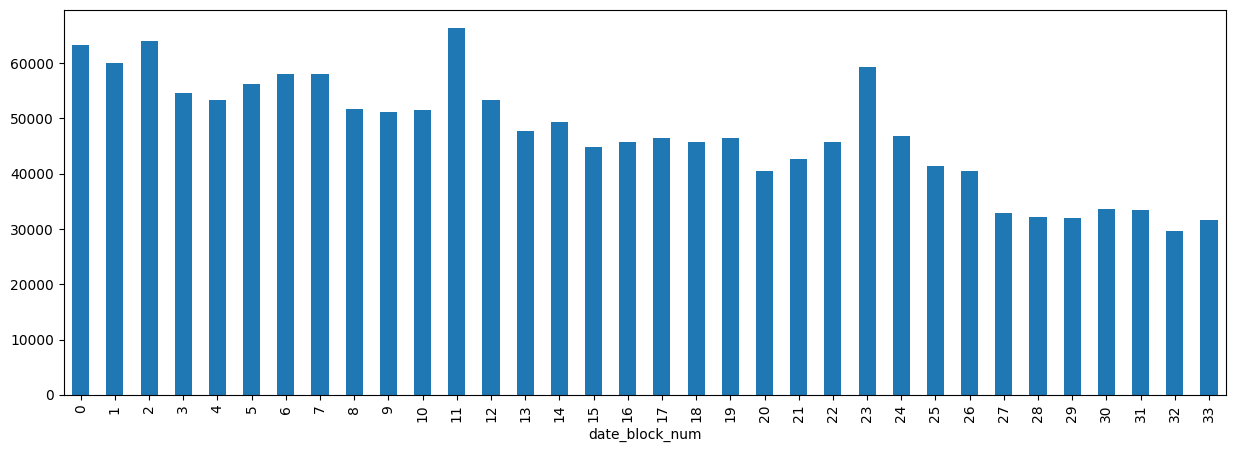

In [100]:
monthly_sales['date_block_num'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

In [101]:
item_categories

,category_name,category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4
...,...,...
79,Service,79
80,Service - Tickets,80
81,Blank media (spire),81
82,Blank media (piece),82


In [102]:
# Merge with items, item_categories, and shops
monthly_sales = monthly_sales.merge(items, on='item_id', how='left')
monthly_sales = monthly_sales.merge(item_categories, on='category_id', how='left')
monthly_sales = monthly_sales.merge(shops, on='shop_id', how='left')


In [114]:
def create_lag_features(df, lags, group_cols, target_col):
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df.groupby(group_cols)[target_col].shift(lag)
    return df

lags = [1, 2, 3, 6]
monthly_sales = create_lag_features(monthly_sales, lags, ['shop_id', 'item_id'], 'item_cnt_month')
monthly_sales.fillna(0, inplace=True)

# Add rolling mean
monthly_sales['item_cnt_mean_3'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_month'].transform(lambda x: x.rolling(3, 1).mean()).fillna(0)


In [21]:
import cx_Oracle
cx_Oracle.init_oracle_client(lib_dir=r"C:\oracle")

In [73]:
import pandas as pd
import cx_Oracle
from sqlalchemy import create_engine

# Define your connection details
dsn_tns = cx_Oracle.makedsn('reade.forest.usf.edu', 1521, sid='cdb9')  # Use SID instead of service name as shown in the image
# Establish the connection
conn = cx_Oracle.connect(user='DW149', password='sudheer', dsn=dsn_tns)

# Create a cursor object
cursor = conn.cursor()

# Verify the connection
print("Connection successful!")

  

Connection successful!


In [24]:
item_categories.rename(columns={'category_id': 'item_category_id'}, inplace=True)


In [103]:
item_categories.rename(columns={'category_name': 'item_category_name'}, inplace=True)

sales_train.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)  # Example if needed


In [104]:
shop.isnull().sum()

shop_id           0
shop_name         0
city              0
region            0
shop_type         0
shop_size_sqft    0
dtype: int64

In [76]:
shop=pd.read_csv('shops_with_data.csv')
load_to_oracle(shop, 'shops_data')                      # Independent table


Data loaded successfully into shops_data!


In [ ]:
import pandas as pd
import cx_Oracle

# Function to load DataFrame to Oracle
def load_to_oracle(df, table_name):
    cols = ','.join(list(df.columns))
    placeholders = ','.join([':' + str(i+1) for i in range(len(df.columns))])
    sql = f'INSERT INTO {table_name} ({cols}) VALUES ({placeholders})'
    
    data = [tuple(x) for x in df.to_numpy()]
    cursor.executemany(sql, data)
    conn.commit()

# Rename the column to match the Oracle table schema
item_categories.rename(columns={'category_id': 'item_category_id'}, inplace=True)

# Load data into Oracle tables in the correct order
load_to_oracle(item_categories, 'item_categories_data')  # Parent table
load_to_oracle(shops, 'shops_data')                      # Independent table
load_to_oracle(items, 'items_data')                      # Dependent on item_categories_raw
 

In [105]:
import re
def preprocess_shop_name(name):
    # Remove unnecessary quotes and specific terms
    name = re.sub(r'[!,"()]', '', name)  # Remove specific characters

    name = name.replace('"', '')  # Remove all double quotes
    name = name.replace("TC", "").replace("SEC", "").replace("TK", "")  # Remove specific terms
    name = name.strip()  # Remove leading and trailing whitespace
    # Capitalize each word for consistency
    name = ' '.join(word.capitalize() for word in name.split())
    return name

# Apply the preprocessing function to the shop_name column
shops['shop_name'] = shops['shop_name'].apply(preprocess_shop_name)

load_to_oracle(shops, 'shops_data')                      # Independent table


Error on row 1: ('Yakutsk Ordzhonikidze 56 Francs', 0)
Error message: ORA-01400: cannot insert NULL into ("DW149"."SHOPS_DATA"."CITY")
Help: https://docs.oracle.com/error-help/db/ora-01400/


IntegrityError: ORA-01400: cannot insert NULL into ("DW149"."SHOPS_DATA"."CITY")
Help: https://docs.oracle.com/error-help/db/ora-01400/

In [106]:
def load_to_oracle_in_batches(df, table_name, batch_size=1000):
    cols = ','.join(list(df.columns))
    placeholders = ','.join([':' + str(i+1) for i in range(len(df.columns))])
    sql = f'INSERT INTO {table_name} ({cols}) VALUES ({placeholders})'
    
    # Prepare data as a list of tuples
    data = [tuple(x) for x in df.to_numpy()]
    
    # Insert data in batches
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]  # Get the current batch
        cursor.executemany(sql, batch)
        conn.commit()  # Commit each batch to avoid memory issues
        print(f"Batch {i // batch_size + 1} inserted successfully.")

    print("All batches inserted successfully.")


In [107]:
item_categories.shape, shops.shape, items.shape, sales_train.shape

((84, 2), (60, 2), (22170, 3), (2935847, 6))

In [108]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_month
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [109]:
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')
sales_train.rename(columns={'date': 'transaction_date'}, inplace=True)

In [ ]:
sales_train.rename(columns={'item_cnt_month': 'item_cnt_day'}, inplace=True)
sales_train

,transaction_date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [40]:
# Load data into Oracle table in batches of 1000 rows
load_to_oracle_in_batches(sales_train, 'sales_transactions', batch_size=1000)


Batch 1 inserted successfully.
Batch 2 inserted successfully.
Batch 3 inserted successfully.
Batch 4 inserted successfully.
Batch 5 inserted successfully.
Batch 6 inserted successfully.
Batch 7 inserted successfully.
Batch 8 inserted successfully.
Batch 9 inserted successfully.
Batch 10 inserted successfully.
Batch 11 inserted successfully.
Batch 12 inserted successfully.
Batch 13 inserted successfully.
Batch 14 inserted successfully.
Batch 15 inserted successfully.
Batch 16 inserted successfully.
Batch 17 inserted successfully.
Batch 18 inserted successfully.
Batch 19 inserted successfully.
Batch 20 inserted successfully.
Batch 21 inserted successfully.
Batch 22 inserted successfully.
Batch 23 inserted successfully.
Batch 24 inserted successfully.
Batch 25 inserted successfully.
Batch 26 inserted successfully.
Batch 27 inserted successfully.
Batch 28 inserted successfully.
Batch 29 inserted successfully.
Batch 30 inserted successfully.
Batch 31 inserted successfully.
Batch 32 inserted

In [39]:
sales_train.duplicated().sum()

6

In [23]:
#close

cursor.close()

In [115]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Define features and target
features = [
    'date_block_num', 'shop_id', 'item_id', 'item_price',
    'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
    'item_cnt_month_lag_3', 'item_cnt_mean_3'
]
X = monthly_sales[features]
y = monthly_sales['item_cnt_month']

 

In [116]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, train_size=0.1, random_state=42)


In [117]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, train_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160912, 8), (1448211, 8), (160912,), (1448211,))

In [118]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, train_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Wrap the fit method to show progress
class ProgressBarRF(RandomForestRegressor):
    def fit(self, X, y):
        # Set tqdm to monitor the progress of the fitting process
        with tqdm(total=self.n_estimators, desc="Training Random Forest", unit="tree") as pbar:
            for _ in super().fit(X, y):
                pbar.update(1)
        return self

# Your original training code
rf = ProgressBarRF(n_estimators=100, random_state=42)

# Assuming X_train and y_train are already defined
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)


Training Random Forest: 100%|██████████| 100/100 [00:40<00:00,  2.50tree/s]


Training Random Forest: 100%|██████████| 100/100 [00:39<00:00,  2.53tree/s]


Random Forest MAE: 0.10426733397274293


C:\Users\sudhe\AppData\Local\Temp\ipykernel_26484\3859106191.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_importance.index, palette='viridis')


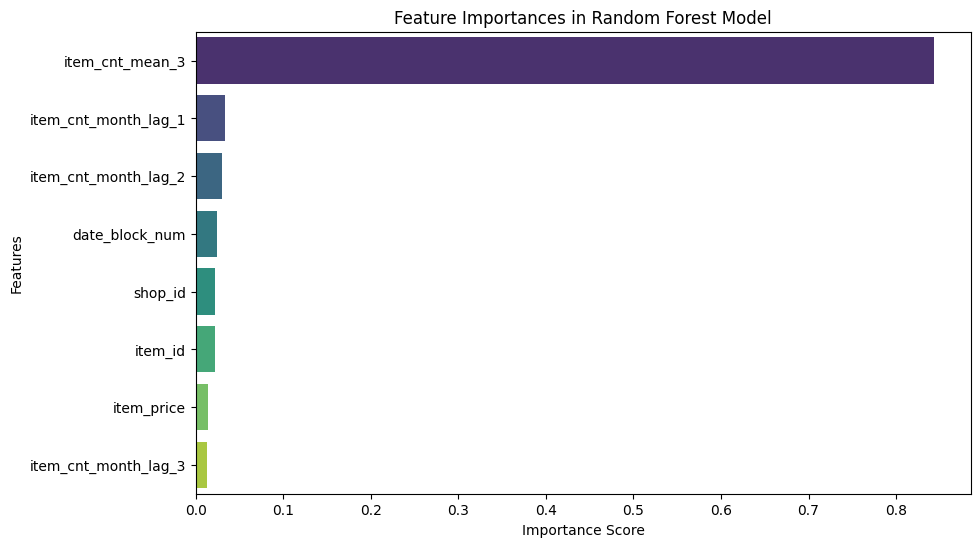

In [119]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, train_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Wrap the fit method to show progress
class ProgressBarRF(RandomForestRegressor):
    def fit(self, X, y):
        # Set tqdm to monitor the progress of the fitting process
        with tqdm(total=self.n_estimators, desc="Training Random Forest", unit="tree") as pbar:
            for _ in super().fit(X, y):
                pbar.update(1)
        return self

# Your original training code
rf = ProgressBarRF(n_estimators=100, random_state=42)

# Assuming X_train and y_train are already defined
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Random Forest MAE: {mae}')
 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances
importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance, y=feature_importance.index, palette='viridis')
plt.title('Feature Importances in Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


<Axes: xlabel='item_cnt_month'>

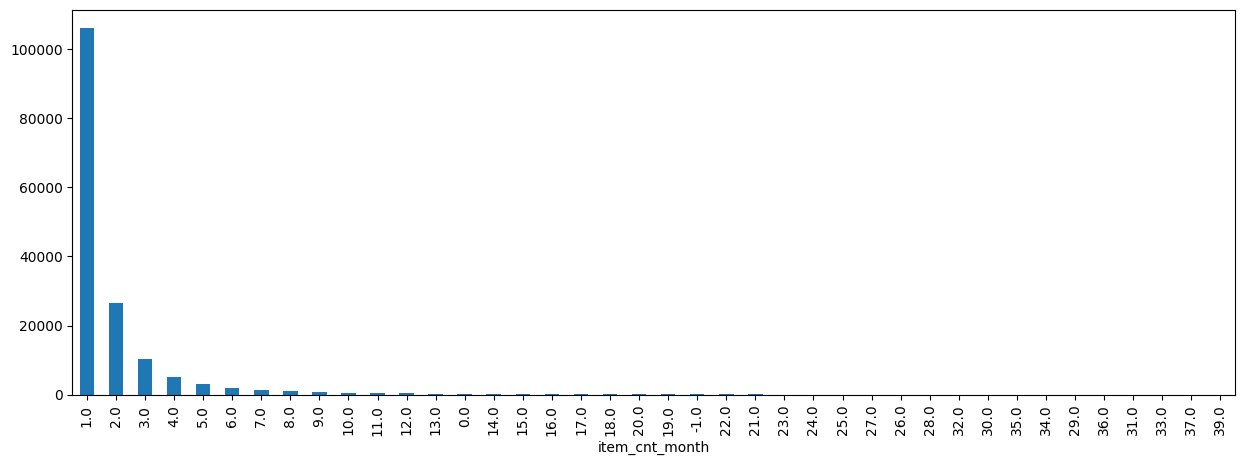

In [120]:
y_train.value_counts()[y_train.value_counts()>20].plot(kind='bar', figsize=(15, 5))